In [27]:
import pandas as pd
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

Initializing the data paths for referencing

In [28]:
data_path = "./Moringa_NCWSC_Dataset.xlsx"
parq_path = './nwcs_dataset.parquet'

In [29]:
# Trying to view the number and naming of sheets we will be working with
xls = pd.ExcelFile(data_path)
for sheet in xls.sheet_names:
    print(sheet)

AUGUST_2024
SEP_2024
OCT_2024
NOV_2024
DEC_2024
JAN_2025
FEB_2025
MAR_2025
APR_2025
MAY_2025


Since the data is too big and is taking too long to run because of the size,
we will convert it to parquet for ease in loading and for preliminary exploratory analysis

In [30]:
def excel_to_parquet_concat(excel_path, parquet_path):
    # Creating a map for the columns
    column_mapping = {
        "CVSTALLATION_KEY": "INSTALLATION_KEY",
        "REGION_AD": "REGION",
        "ZONE_AD": "ZONE",
        "SUB_ZONE_AD": "SUB_ZONE"
    }

    # Load workbook to get sheet names
    xls = pd.ExcelFile(excel_path)
    sheet_names = xls.sheet_names

    big_df = None

    # tqdm for showing a progress bar
    for sheet in tqdm(sheet_names, desc="Processing sheets", unit="sheet"):
        # Read sheet
        df = pd.read_excel(excel_path, sheet_name=sheet)

        # Rename columns
        df.rename(columns=lambda c: column_mapping.get(c.strip(), c.strip()), inplace=True)

        # 🟢 Extract Month and Year from sheet name
        # Example: "AUGUST_2024" → month = "AUGUST", year = 2024
        try:
            month, year = sheet.split("_")
        except ValueError:
            month, year = sheet, None  # fallback in case sheet name doesn’t fit

        df["MONTH"] = month.capitalize()   # Ensure nice formatting
        df["YEAR"] = year

        # Align columns with existing big_df
        if big_df is None:
            big_df = df
        else:
            big_df = pd.concat([big_df, df], axis=0, ignore_index=True, join="outer")

    # Convert dtypes
    big_df = big_df.convert_dtypes()

    # 🔑 Fix mixed object columns → force string
    for col in big_df.columns:
        if str(big_df[col].dtype) == "object":
            big_df[col] = big_df[col].astype(str)

    # Save as parquet
    big_df.to_parquet(parquet_path, engine="pyarrow", index=False)

    print(f"✅ Done! All sheets merged and saved to {parquet_path}")
    return big_df


In [31]:
# Running the function above to convert the data to parquet
excel_to_parquet_concat(data_path, parq_path)

Processing sheets:   0%|          | 0/10 [01:00<?, ?sheet/s]


KeyboardInterrupt: 

In [32]:
# Loading the converted dataset
df = pd.read_parquet('./nwcs_dataset.parquet')

In [33]:
print(f"The file has the following columns: \n{"--" * 20}\n {df.columns} \n")
print(f"{"--" * 20}\n A total of {len(df.columns)} columns and a shape of {df.shape} rows and columns respectively")

The file has the following columns: 
----------------------------------------
 Index(['REGION', 'ZONE', 'SUB_ZONE', 'INSTALLATION_KEY', 'INST_TYPE_CODE',
       'INSTALLATION_TYPE_DESC', 'ACTIVITY_TYPE_INS', 'METER_SIZE',
       'BILL_DATE', 'BILL_ESTIMATE_ACTUAL', 'BILL_VALID_INVALID',
       'MAIN_SERVICE', 'SHADOW_SERVICE', 'WATER_AMOUNT', 'SEWER_AMOUNT',
       'BILL_AMOUNT', 'BILL_VOLUME', 'MONTH', 'YEAR', 'METER_RENT_AMOUNT',
       'ADDRESS', 'BILL_DAYS'],
      dtype='object') 

----------------------------------------
 A total of 22 columns and a shape of (2464244, 22) rows and columns respectively


In [34]:
# Viewing the first few columns
df.head()

,REGION,ZONE,SUB_ZONE,INSTALLATION_KEY,INST_TYPE_CODE,INSTALLATION_TYPE_DESC,ACTIVITY_TYPE_INS,METER_SIZE,BILL_DATE,BILL_ESTIMATE_ACTUAL,...,SHADOW_SERVICE,WATER_AMOUNT,SEWER_AMOUNT,BILL_AMOUNT,BILL_VOLUME,MONTH,YEAR,METER_RENT_AMOUNT,ADDRESS,BILL_DAYS
0,DAGORETTI,KILIMANI-KILELESHWA,HURLINGHAM,CV-7000001,DOM,DOMESTIC,NORMAL SINGLE-DWELLING UNIT,0.5,2024-08-09 00:00:00,ACTUAL,...,SEW,90.0,86.0,176.0,2,August,2024,<NA>,<NA>,<NA>
1,CENTRAL,KAMUKUNJI,EASTLEIGH,CV-7000002,DOM,DOMESTIC,NORMAL SINGLE-DWELLING UNIT,0.5,2024-08-08 00:00:00,ESTIMATED,...,SEW,0.0,0.0,0.0,0,August,2024,<NA>,<NA>,<NA>
2,CENTRAL,KAMUKUNJI,EASTLEIGH,CV-7000003,DOM,DOMESTIC,NORMAL SINGLE-DWELLING UNIT,0.5,2024-08-02 00:00:00,ESTIMATED,...,SEW,1978.0,1231.0,3209.0,31,August,2024,<NA>,<NA>,<NA>
3,CENTRAL,KAMUKUNJI,MOI AIR BASE_BAHATI,CV-7000004,DOM,DOMESTIC,NORMAL SINGLE-DWELLING UNIT,0.5,2024-08-14 00:00:00,ACTUAL,...,SEW,315.0,215.0,530.0,7,August,2024,<NA>,<NA>,<NA>
4,LANGATA,SOUTH C- NAIROBI WEST,SOUTH C_MOMBASA RD,CV-7000005,DOM,DOMESTIC,NORMAL SINGLE-DWELLING UNIT,0.5,2024-08-05 00:00:00,ACTUAL,...,SEW,2860.0,1834.0,4694.0,44,August,2024,<NA>,<NA>,<NA>


### Checking for mising values

In [35]:
# Percentage of missing values per column
pd.DataFrame({"Missing values":df.isna().sum(),
"sorted %" : df.isna().sum() / len(df) * 100}).sort_values(by="sorted %",ascending=False)

,Missing values,sorted %
ACTIVITY_TYPE_INS,2227801,90.405049
ADDRESS,2217447,89.984880
METER_RENT_AMOUNT,1970981,79.983192
BILL_DAYS,986360,40.026880
BILL_VALID_INVALID,246343,9.996697
BILL_ESTIMATE_ACTUAL,8933,0.362505
METER_SIZE,8933,0.362505
SUB_ZONE,1594,0.064685
REGION,798,0.032383
ZONE,798,0.032383


### Dealing with the missing values

We will Employ the following method to mitigate the effects of the missing values.
- For columns with greater than 80% of missing values we will drop them.
- For Numeric columns such as the meter size we will fill with the mode.
- For the zones and sub-zones we will infer or fill them manually.
- For the bill estimate actual we will drop the estimated figures and remain with the actual figures
- The BILL_VALID_INVALID column will be filled with valid since all the bills are valid

In [36]:
# Dropping the unnecessary columns
dropped_cols = ['ACTIVITY_TYPE_INS','ADDRESS','METER_RENT_AMOUNT','BILL_DATE','BILL_DAYS']
df_ncws = df.drop(columns=dropped_cols)

# Fill BILL_VALID_INVALID with "VALID"
df_ncws['BILL_VALID_INVALID'] = df_ncws['BILL_VALID_INVALID'].fillna('VALID')

# Fill METER_SIZE with mode
df_ncws['METER_SIZE'] = df_ncws['METER_SIZE'].fillna(df_ncws['METER_SIZE'].mode()[0])

# Drop rows with Null values in SUB_ZONE
df_copy = df_ncws[df_ncws['SUB_ZONE'].notna()]

# Filter to keep only ACTUAL bills (remove estimates) and fill NAs with "ACTUAL"
df_cleaned = df_copy.query("BILL_ESTIMATE_ACTUAL not in (['ESTIMATE', 'ESTIMATED'])")\
    .assign(BILL_ESTIMATE_ACTUAL=lambda d: d['BILL_ESTIMATE_ACTUAL'].fillna("ACTUAL"))

# Convert the following missclassified columns to numeric
cols_to_clean = ['WATER_AMOUNT', 'SEWER_AMOUNT', 'BILL_AMOUNT', 'BILL_VOLUME', 'YEAR']
df_cleaned[cols_to_clean] = df_cleaned[cols_to_clean].apply(pd.to_numeric, errors="coerce")

# Fill Nans with 0.0 for the converted columns
df_cleaned[cols_to_clean] = df_cleaned[cols_to_clean].fillna(0.0, axis=1)

# Drop rows with placeholder dash ("-")
df_cleaned = df_cleaned[~df_cleaned[cols_to_clean].applymap(
    lambda x: isinstance(x, str) and x.strip() == "-"
).any(axis=1)]

In [37]:
df_cleaned.dtypes

REGION                    string[python]
ZONE                      string[python]
SUB_ZONE                  string[python]
INSTALLATION_KEY          string[python]
INST_TYPE_CODE            string[python]
INSTALLATION_TYPE_DESC    string[python]
METER_SIZE                       Float64
BILL_ESTIMATE_ACTUAL      string[python]
BILL_VALID_INVALID        string[python]
MAIN_SERVICE              string[python]
SHADOW_SERVICE            string[python]
WATER_AMOUNT                     float64
SEWER_AMOUNT                     float64
BILL_AMOUNT                      float64
BILL_VOLUME                      float64
MONTH                     string[python]
YEAR                             float64
dtype: object

In [38]:
df_cleaned.isna().sum()

REGION                    0
ZONE                      0
SUB_ZONE                  0
INSTALLATION_KEY          0
INST_TYPE_CODE            0
INSTALLATION_TYPE_DESC    0
METER_SIZE                0
BILL_ESTIMATE_ACTUAL      0
BILL_VALID_INVALID        0
MAIN_SERVICE              0
SHADOW_SERVICE            0
WATER_AMOUNT              0
SEWER_AMOUNT              0
BILL_AMOUNT               0
BILL_VOLUME               0
MONTH                     0
YEAR                      0
dtype: int64

### % of Values with negative numbers
================================================================
 - All the columns have been converted to their righful dtypes
 - We still have values that are negative, which could impact our data.
 - These values could represent:

 | Case                          | Explanation                                                                 |
|-------------------------------|-----------------------------------------------------------------------------|
| Bill corrections or adjustments | Sometimes utilities issue a credit to a customer if they were overbilled earlier. |
| Refunds or reversals           | If a customer pays in advance or has an overpayment, the system might use negative billing entries to offset future bills. |
| Wrong readings | if a meter reading was entered incorrectly and later corrected. |

In [39]:
# Inserting a new column for filtering the negative numbers
df_cleaned["NEGATIVE"] = df_cleaned[cols_to_clean].lt(0).any(axis=1)

df_cleaned["NEGATIVE"].value_counts(normalize=True)

NEGATIVE
False    0.987131
True     0.012869
Name: proportion, dtype: float64

- We have approximately 99% of the data with debited bills and about 1 % of the data containing credited amounts.
- We will use the debited amounts for ease of analysis.
- For this process we will filter the 1 %

In [40]:
df_filtered = df_cleaned[(~df_cleaned['NEGATIVE']) & (df_cleaned["REGION"].ne("REGION"))]

df_filtered.head()

,REGION,ZONE,SUB_ZONE,INSTALLATION_KEY,INST_TYPE_CODE,INSTALLATION_TYPE_DESC,METER_SIZE,BILL_ESTIMATE_ACTUAL,BILL_VALID_INVALID,MAIN_SERVICE,SHADOW_SERVICE,WATER_AMOUNT,SEWER_AMOUNT,BILL_AMOUNT,BILL_VOLUME,MONTH,YEAR,NEGATIVE
0,DAGORETTI,KILIMANI-KILELESHWA,HURLINGHAM,CV-7000001,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,90.0,86.0,176.0,2.0,August,2024.0,False
3,CENTRAL,KAMUKUNJI,MOI AIR BASE_BAHATI,CV-7000004,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,315.0,215.0,530.0,7.0,August,2024.0,False
4,LANGATA,SOUTH C- NAIROBI WEST,SOUTH C_MOMBASA RD,CV-7000005,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,2860.0,1834.0,4694.0,44.0,August,2024.0,False
5,LANGATA,WOODLEY_UPPERHILL,UPPERHILL,CV-7000006,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,90.0,86.0,176.0,2.0,August,2024.0,False
6,LOWER EMBAKASI,IMARA DAIMA,PIPELINE,CV-7000008,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,90.0,86.0,176.0,2.0,August,2024.0,False


## Exploratory Data Analysis

For this step we will look at the following elements;

A. Univariate

1. Distribution of clients per region
2. Revenue generated per region
3. Which installation types have the highest revenue
4. Monthly water usage over time
5. Sewerage services per region
6. Water services per region.

In [41]:
# Here we will create a class for plotting the graphs to make our code reusable
class Plot:
    @staticmethod
    def barplot(data, x, y, title, x_label=None, y_label=None, ):
        plt.figure(figsize=(10,8))
        sns. barplot(
            x=x,
            y=y,
            data = data
        )
        plt.ylabel(y_label),
        plt.xlabel(x_label)
        plt.title(title)

        return plt.show()
    
    @staticmethod
    def lineplot(data, x, y, title, x_label=None, y_label=None):
        plt.figure(figsize=(12,6))
        plt.plot(data[x], data[y], marker='o', color='blue')
        plt.xticks(rotation=45)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### 1. DISTRIBUTION OF CLIENTS PER REGION

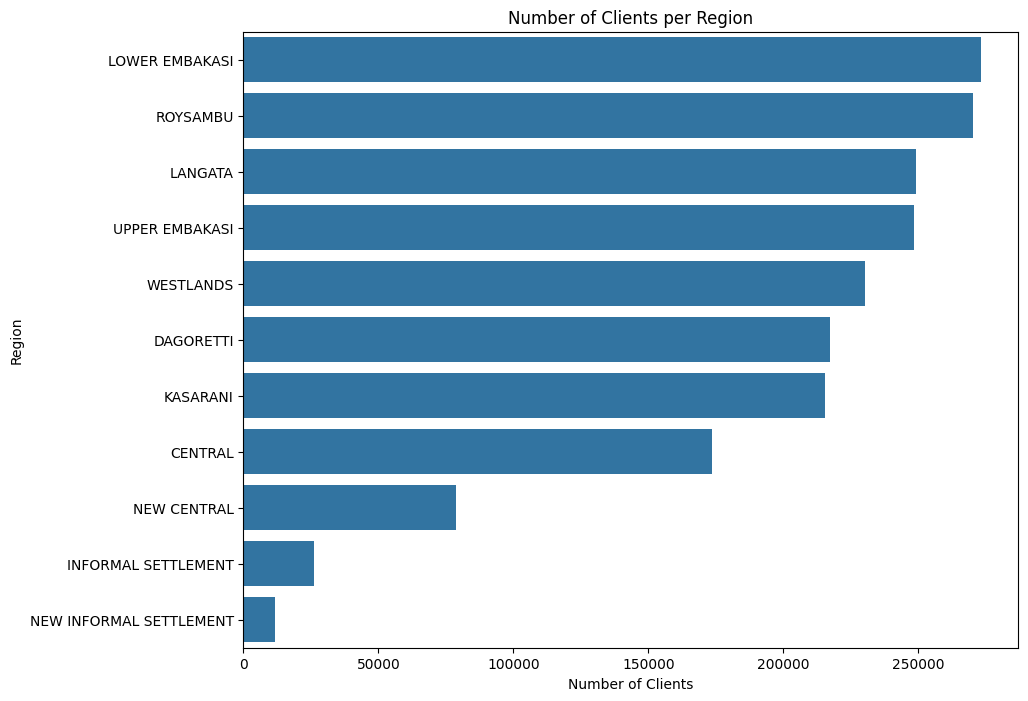

In [42]:
client_counts = pd.DataFrame(df_filtered.groupby("REGION")["INSTALLATION_KEY"].count().sort_values(ascending=False))
df_clients = client_counts.reset_index()
df_clients.columns = ['REGION', 'CLIENT_COUNT']

Plot.barplot(data=df_clients, x='CLIENT_COUNT', y='REGION',y_label="Region", x_label="Number of Clients",title="Number of Clients per Region")

The Lower Embakasi, Roysambu, and Langata regions account for the largest share of the customer base, indicating that these areas have the highest number of connections or billed installations. In contrast, informal settlements represent the smallest share of customers, reflecting fewer registered connections or metered accounts.

### 3. REVENUES GENERATED PER REGION

Here we will group the data into zones/region based on the amount of money the customers spent on the average water and sewerage bills

In [43]:
zone = df_filtered.groupby('ZONE')["BILL_AMOUNT"].sum()
zone = zone.reset_index()

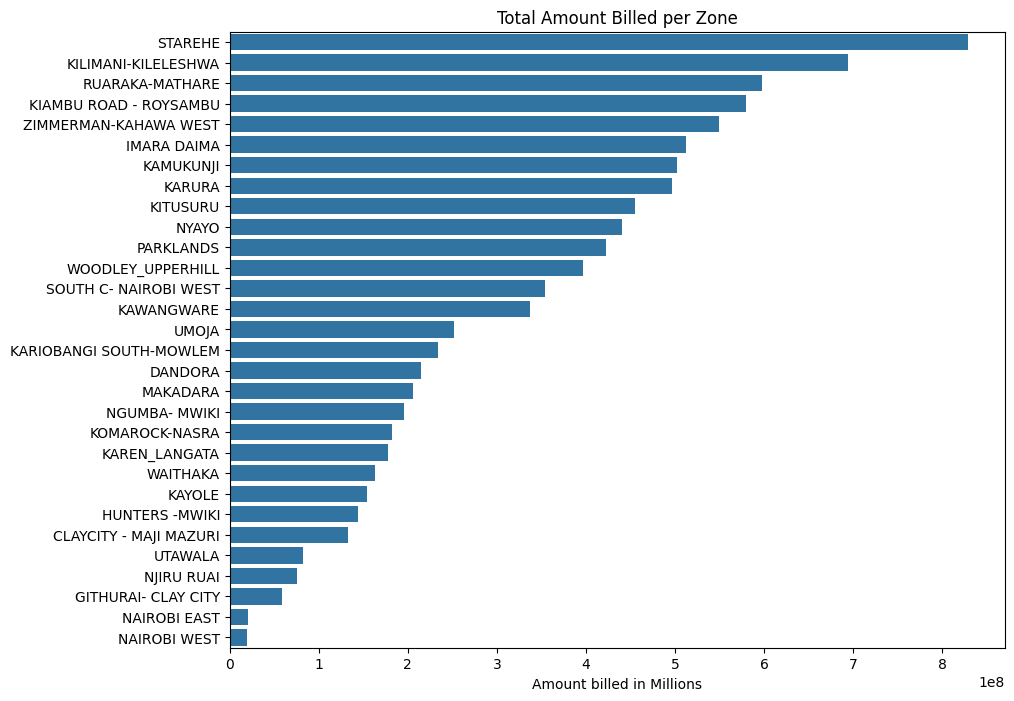

In [44]:
Plot.barplot(zone.sort_values(by='BILL_AMOUNT',ascending=False), x='BILL_AMOUNT',y='ZONE', x_label='Amount billed in Millions', title="Total Amount Billed per Zone")

The data shows that Starehe, Kilimani, Kileleshwa, and Ruaraka are the regions with the highest billed amounts per zone. This indicates that water consumption in these areas is significantly higher compared to other zones, which could be due to a combination of factors such as larger households, commercial or high-demand connections, or higher-income areas with greater water usage.

From a revenue perspective, these zones represent the largest contributors to overall water billing.

#### Checking the variations in amount billed within the different zones

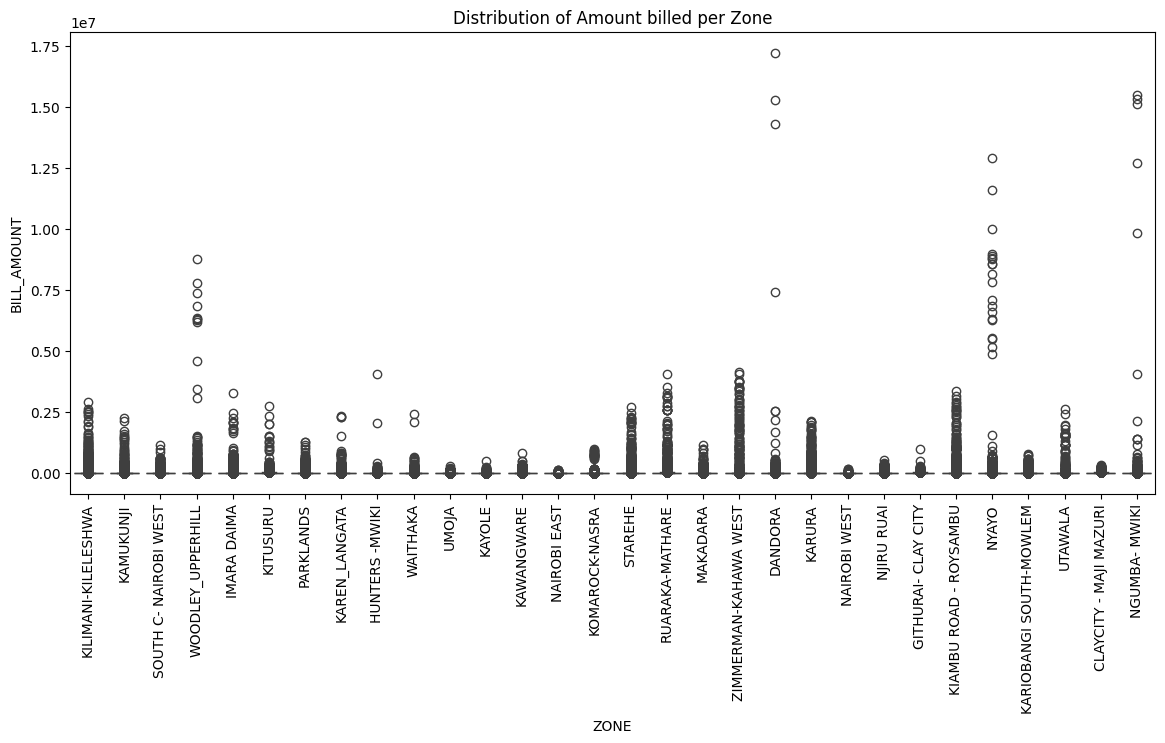

In [45]:
df_plot = df_filtered
plt.figure(figsize=(14,6))
sns.boxplot(x="ZONE", y="BILL_AMOUNT", data=df_plot)
plt.xticks(rotation=90)
plt.title("Distribution of Amount billed per Zone")
plt.show()

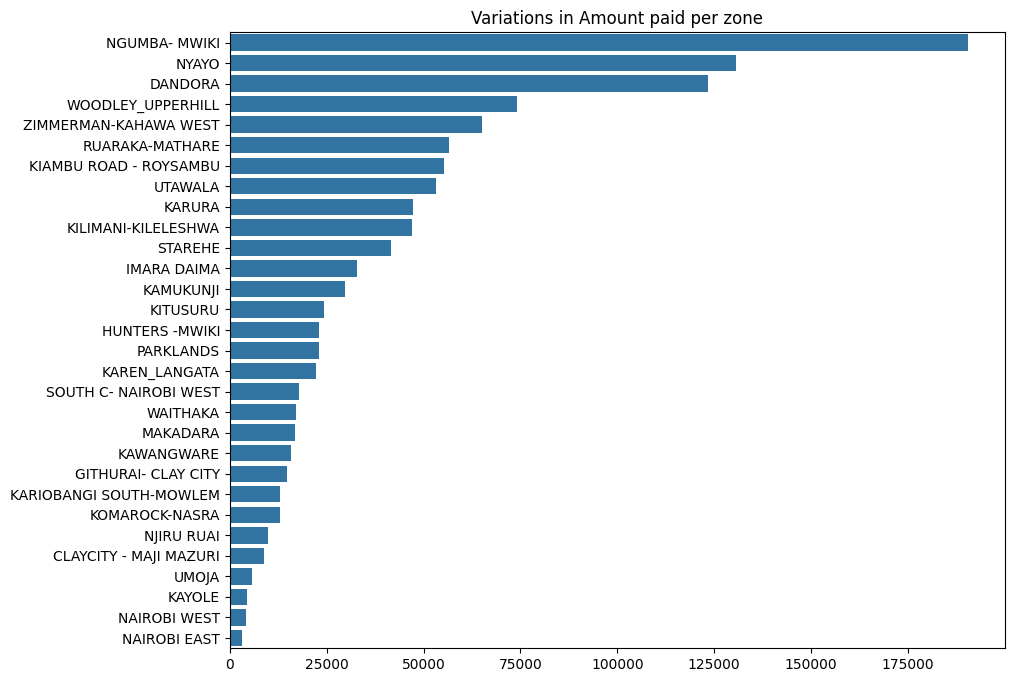

In [46]:
# Group by 'ZONE' and calculate standard deviation of 'BILL_AMOUNT'
zone_variability = df_filtered.groupby('ZONE')['BILL_AMOUNT'].std().reset_index()

# Rename column for clarity
zone_variability.columns = ['ZONE', 'STD_BILL_AMOUNT']

# Sort descending to see which zone has the highest variability
zone_variability_sorted = zone_variability.sort_values(by='STD_BILL_AMOUNT', ascending=False)

Plot.barplot(zone_variability_sorted, "STD_BILL_AMOUNT", "ZONE","Variations in Amount paid per zone")


From the graph above, we can observe clear differences in the variability of billed water amounts across zones. The Ngumba - Mwiki area exhibits the highest variation in billed amounts, which suggests a wide range of water consumption patterns. This could be due to a combination of high-volume users, irregular consumption habits, or differences in connection types such as residential versus commercial. Such variability might also indicate potential inefficiencies in billing or instances of unmetered usage.

The Nyayo and Dandora zones also show relatively high variability, although not as extreme as Ngumba - Mwiki. These areas may contain a mix of consumer types, leading to fluctuations in billed amounts. On the other hand, the Nairobi East zone shows the lowest variation, implying that water consumption is more uniform across users. This consistency could reflect standardized consumption patterns, fewer high-volume users, or better-metered and controlled distribution.

From a water management and revenue perspective, zones with higher variation warrant closer attention. They may benefit from targeted audits, leak detection, or consumption monitoring to reduce losses and improve billing accuracy. Conversely, zones with low variation are more predictable and may require less intensive monitoring, allowing resources to be focused on higher-risk areas.

### 3. REVENUES PER INSTALLATION TYPE

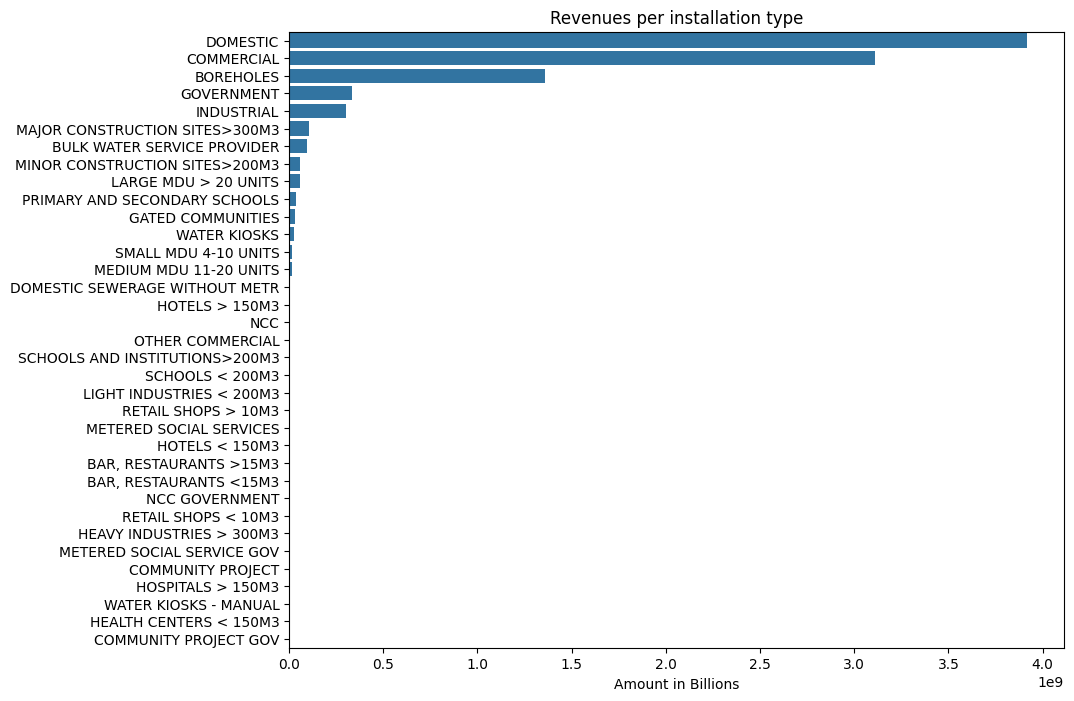

In [47]:
revenues_per_type = df_filtered.groupby("INSTALLATION_TYPE_DESC")["BILL_AMOUNT"].sum().sort_values(ascending=False)
# Convert Series to DataFrame
revenues_df = revenues_per_type.reset_index()
revenues_df.columns = ["INSTALLATION_TYPE", "BILL_AMOUNT"]

Plot.barplot(revenues_df, "BILL_AMOUNT", "INSTALLATION_TYPE", title="Revenues per installation type", x_label='Amount in Billions')


### 4. MONTHLY USAGE OVER TIME

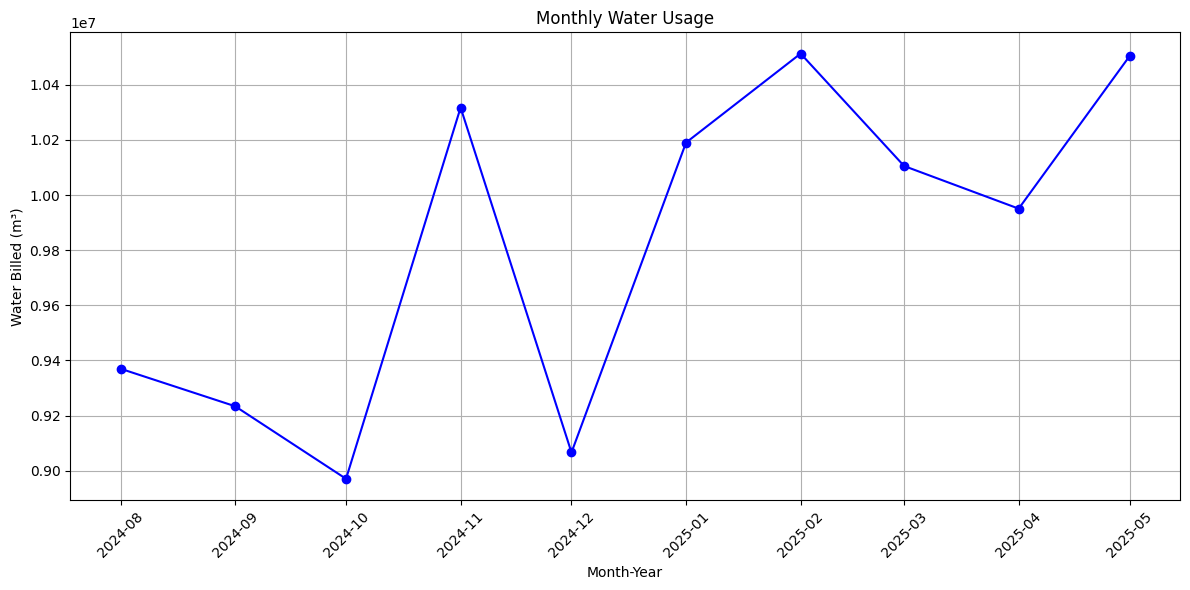

In [48]:
# Here we will group the columns by month and year and sum total the water amount to get the monthly revenue
monthly_rev = df_filtered.groupby(["MONTH", "YEAR"])["BILL_VOLUME"].sum().sort_values(ascending=False)

# Here we will convert our series to a DataFrame
df_monthly = monthly_rev.reset_index()

month_map = {
    "January":"Jan","February":"Feb","March":"Mar","April":"Apr","May":"May","June":"Jun",
    "July":"Jul","August":"Aug","September":"Sept","Sep":"Sept","October":"Oct","November":"Nov","December":"Dec"
}
df_monthly['MONTH'] = df_monthly['MONTH'].replace(month_map)

mask = (df_monthly['MONTH'].str.startswith('Sep')) & (df_monthly['YEAR'] == 2024)

df_monthly.loc[mask, 'DATE'] = pd.to_datetime('2024-09-01')

df_monthly['DATE'] = pd.to_datetime(
    df_monthly['MONTH'] + '-' + df_monthly['YEAR'].astype(int).astype(str),
    format='%b-%Y',
    errors='coerce'
)


# Create a proper datetime
# df_monthly['DATE'] = pd.to_datetime(df_monthly['MONTH'].astype(str) + '-' + df_monthly['YEAR'].astype(int).astype(str), format='%b-%Y', errors='coerce')

# Sort by date
df_monthly = df_monthly.sort_values('DATE')

# Use the Plot class
Plot.lineplot(
    df_monthly,
    x='DATE',
    y='BILL_VOLUME',
    title='Monthly Water Usage',
    x_label='Month-Year',
    y_label='Water Billed (m³)'
)

The monthly billed water volumes reveal a clear upward trend from late 2024 into early 2025. The lowest consumption was recorded in October 2024 at about 8.97 million m³, closely followed by December 2024 (9.07 million m³) and September 2024 (9.23 million m³). Usage then increased steadily, peaking in February 2025 at 10.51 million m³, with similarly high volumes in May 2025 (10.50 million m³) and January 2025 (10.19 million m³).

This progression suggests a possible seasonal effect, where demand was relatively lower towards the end of 2024 and rose in the first quarter of 2025, likely reflecting shifts in consumption patterns or service coverage.

#### % Loss of water

An interesting thing to look at here is the % of water that is lost or volume lost. Over the months

- For this step we will first load in the water produced dataset
- Clean the data and standardize the column names for ease of referencing

In [49]:
# 1. Load in the production volumes
vol_produced = pd.read_csv("Copy of Water_Produced.xlsx - PRODUCTION.csv")
# 3. Rename the columns
vol_produced = vol_produced.loc[:,['MONTH','TOTAL PRODUCTION  (m3)']].rename(columns={'TOTAL PRODUCTION  (m3)': 'TOTAL_PRODUCTION'})
# 2. Remove all the commas
vol_produced['TOTAL_PRODUCTION'] = vol_produced['TOTAL_PRODUCTION'].replace(',', '', regex=True).astype(float)
vol_produced

,MONTH,TOTAL_PRODUCTION
0,Jul-24,15438266.56
1,Aug-24,16286171.66
2,Sept-24,16096105.72
3,Oct-24,15093036.26
4,Nov-24,16366360.14
5,Dec-24,16378781.83
6,Jan-25,18542157.83
7,Feb-25,18696062.58
8,Mar-25,17760442.28
9,Apr-25,18979065.48


In [50]:
monthly_rev_df = monthly_rev.reset_index()
df_monthly

,MONTH,YEAR,BILL_VOLUME,DATE
6,Aug,2024.0,9369921.0,2024-08-01
7,Sept,2024.0,9233875.0,2024-09-01
9,Oct,2024.0,8970674.0,2024-10-01
2,Nov,2024.0,10317314.0,2024-11-01
8,Dec,2024.0,9066178.0,2024-12-01
3,Jan,2025.0,10190324.0,2025-01-01
0,Feb,2025.0,10513042.0,2025-02-01
4,Mar,2025.0,10105291.0,2025-03-01
5,Apr,2025.0,9950653.0,2025-04-01
1,May,2025.0,10503746.0,2025-05-01


In [51]:
# --- Clean df_monthly ---
# Renaming column for consistency
df_monthly = df_monthly.rename(columns={"BILL_VOLUME": "BILLED_VOLUME"})

# Ensuring YEAR is integer
df_monthly["YEAR"] = df_monthly["YEAR"].astype(int)

# Building a clean month-year key"
df_monthly["MONTH_YEAR"] = df_monthly.apply(
    lambda row: (
        row["MONTH"][:4] + "-" + str(int(row["YEAR"]))[-2:]
        if row["MONTH"] == "Sept"
        else row["MONTH"][:3] + "-" + str(int(row["YEAR"]))[-2:]
    ),
    axis=1
)


# --- Clean vol_produced ---
# If it's string with commas clean it, else leave as is
if vol_produced["TOTAL_PRODUCTION"].dtype == "object":
    vol_produced["TOTAL_PRODUCTION"] = (
        vol_produced["TOTAL_PRODUCTION"].str.replace(",", "").astype(float)
    )
else:
    vol_produced["TOTAL_PRODUCTION"] = vol_produced["TOTAL_PRODUCTION"].astype(float)

# Ensuring column name is consistent
vol_produced = vol_produced.rename(columns={"MONTH": "MONTH_YEAR"})

# --- Merge ---
df_merged = pd.merge(
    df_monthly[["MONTH_YEAR", "BILLED_VOLUME"]],
    vol_produced,
    on="MONTH_YEAR",
    how="outer"
)

# --- Calculating losses ---
df_merged["LOSS"] = df_merged["TOTAL_PRODUCTION"] - df_merged["BILLED_VOLUME"]
df_merged["LOSS_PERCENT"] = (
    (df_merged["LOSS"] / df_merged["TOTAL_PRODUCTION"]) * 100
).round(2)

# --- Final result ---
df_result = df_merged[["MONTH_YEAR", "TOTAL_PRODUCTION", "BILLED_VOLUME", "LOSS", "LOSS_PERCENT"]]

df_result = df_result.dropna()

df_result["DATE"] = pd.to_datetime(df_result["MONTH_YEAR"], format="%b-%y")

# Sort by DATE
df_result = df_result.sort_values("DATE").reset_index(drop=True)

df_result

,MONTH_YEAR,TOTAL_PRODUCTION,BILLED_VOLUME,LOSS,LOSS_PERCENT,DATE
0,Aug-24,16286171.66,9369921.0,6916250.66,42.47,2024-08-01
1,Sept-24,16096105.72,9233875.0,6862230.72,42.63,2024-09-01
2,Oct-24,15093036.26,8970674.0,6122362.26,40.56,2024-10-01
3,Nov-24,16366360.14,10317314.0,6049046.14,36.96,2024-11-01
4,Dec-24,16378781.83,9066178.0,7312603.83,44.65,2024-12-01
5,Jan-25,18542157.83,10190324.0,8351833.83,45.04,2025-01-01
6,Feb-25,18696062.58,10513042.0,8183020.58,43.77,2025-02-01
7,Mar-25,17760442.28,10105291.0,7655151.28,43.10,2025-03-01
8,Apr-25,18979065.48,9950653.0,9028412.48,47.57,2025-04-01
9,May-25,19009876.16,10503746.0,8506130.16,44.75,2025-05-01


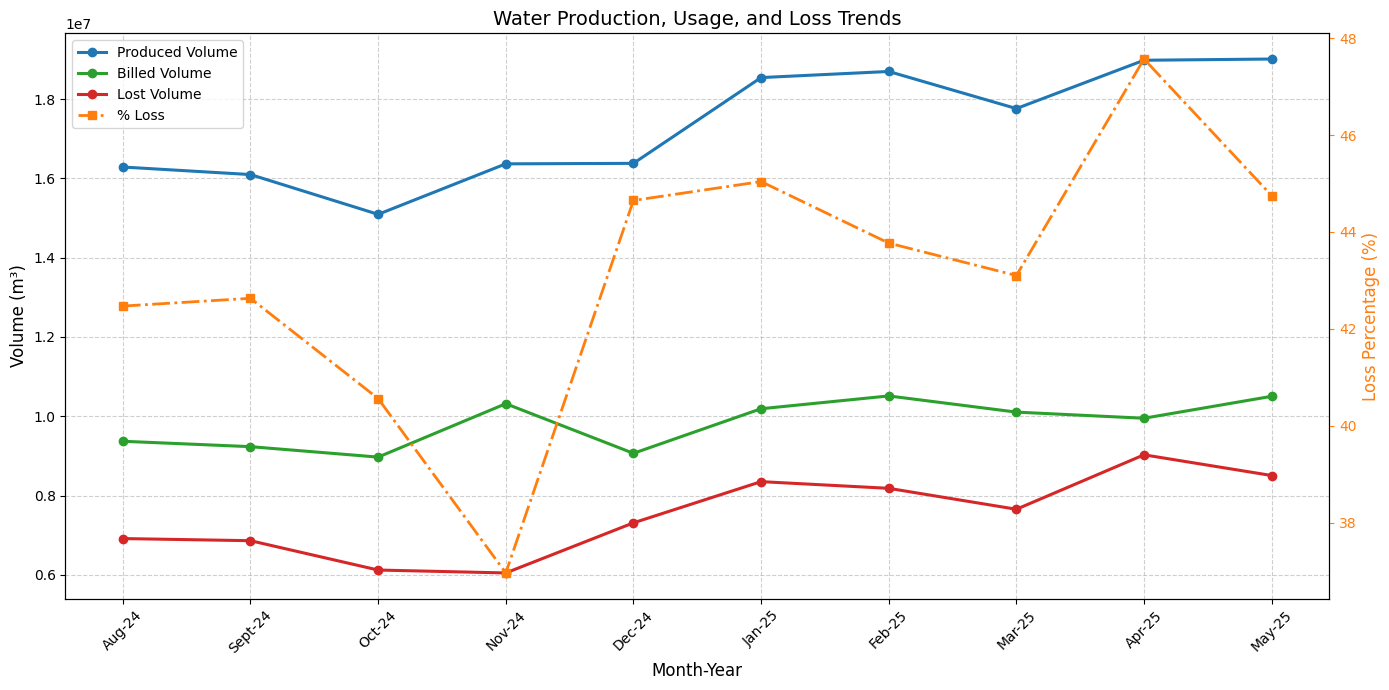

In [52]:
plt.figure(figsize=(14,7))

# --- Left axis (volumes) ---
ax1 = plt.gca()
ax1.plot(df_result["MONTH_YEAR"], df_result["TOTAL_PRODUCTION"], 
         marker="o", linewidth=2.2, label="Produced Volume", color="#1f77b4")
ax1.plot(df_result["MONTH_YEAR"], df_result["BILLED_VOLUME"], 
         marker="o", linewidth=2.2, label="Billed Volume", color="#2ca02c")
ax1.plot(df_result["MONTH_YEAR"], df_result["LOSS"], 
         marker="o", linewidth=2.2, label="Lost Volume", color="#d62728")

# Styling
ax1.set_xlabel("Month-Year", fontsize=12)
ax1.set_ylabel("Volume (m³)", fontsize=12, color="black")
ax1.tick_params(axis="x", rotation=45)
ax1.grid(True, linestyle="--", alpha=0.6)

# --- Right axis (% loss) ---
ax2 = ax1.twinx()
ax2.plot(df_result["MONTH_YEAR"], df_result["LOSS_PERCENT"], 
         marker="s", linestyle="-.", linewidth=2, label="% Loss", color="#ff7f0e")
ax2.set_ylabel("Loss Percentage (%)", fontsize=12, color="#ff7f0e")
ax2.tick_params(axis="y", colors="#ff7f0e")

# --- Title and Legends ---
plt.title("Water Production, Usage, and Loss Trends", fontsize=14, fontweight="light")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left", fontsize=10, frameon=True)

plt.tight_layout()
plt.show()


 - Between August 2024 and May 2025, the data shows a consistent gap between the volume of water produced and the volume that is ultimately billed to consumers. On average, production ranged between 15 and 19 million units per month, while billed consumption remained much lower, hovering around 10 million units. This gap translates into substantial losses, typically between 6 and 9 million units every month.

- When measured as a percentage of production, these losses represent a persistent challenge. The share of water lost fluctuated between about 37 percent and 48 percent during the period under review. November 2024 recorded the lowest loss rate at just under 37 percent, while April 2025 stood out as the month with the highest losses, at nearly 48 percent.

- The overall picture suggests that, despite stable and at times rising production levels, more than 40 percent of the water produced is not being accounted for in revenue.

#### 5. WATER USAGE PER REGION

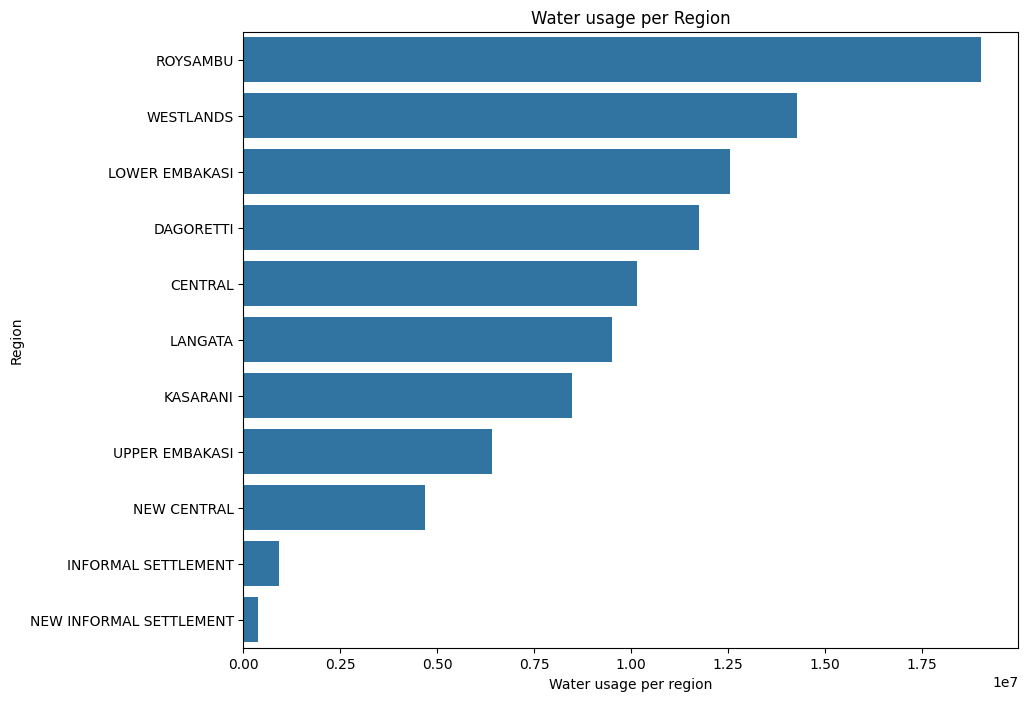

In [53]:
regional_consumption = pd.DataFrame(df_filtered.groupby("REGION")["BILL_VOLUME"].sum().sort_values(ascending=False))
regional_consumption = regional_consumption.reset_index()
regional_consumption.columns = ['REGION', 'BILL_VOLUME']

Plot.barplot(data=regional_consumption, x='BILL_VOLUME', y='REGION',y_label="Region", x_label="Water usage per region",title="Water usage per Region")



The distribution of billed water volumes across regions highlights significant disparities in consumption and demand. Roysambu recorded the highest billed volume at over 19 million units, standing out as the single largest contributor. Westlands followed with nearly 14.3 million units, while Lower Embakasi and Dagoretti also reported substantial billed volumes, exceeding 12.5 million and 11.7 million units respectively.

In the mid-range, Central and Langata registered billed volumes of approximately 10.2 million and 9.5 million units, with Kasarani slightly lower at 8.5 million units. Upper Embakasi trailed further behind at around 6.4 million units.

The lowest billed volumes were concentrated in New Central, Informal Settlements, and New Informal Settlements, which recorded 4.7 million, 0.9 million, and 0.38 million units respectively

#### B. Bivariate Analysis
For this part we will do some correlation:
1. Correlation between bill amount and amount of water used
2. Check the correlation of Water usage, water production and water loss.


In [54]:
# 1. Calculate Correlation between bill amount and amount of water used
correlation = df_filtered['BILL_AMOUNT'].corr(df_filtered['BILL_VOLUME'])
print("Correlation between BILL_AMOUNT and BILL_VOLUME:", correlation)


Correlation between BILL_AMOUNT and BILL_VOLUME: 0.9228611526405756


                  TOTAL_PRODUCTION  BILLED_VOLUME      LOSS  LOSS_PERCENT
TOTAL_PRODUCTION          1.000000       0.799069  0.934729      0.669154
BILLED_VOLUME             0.799069       1.000000  0.533256      0.089258
LOSS                      0.934729       0.533256  1.000000      0.888755
LOSS_PERCENT              0.669154       0.089258  0.888755      1.000000


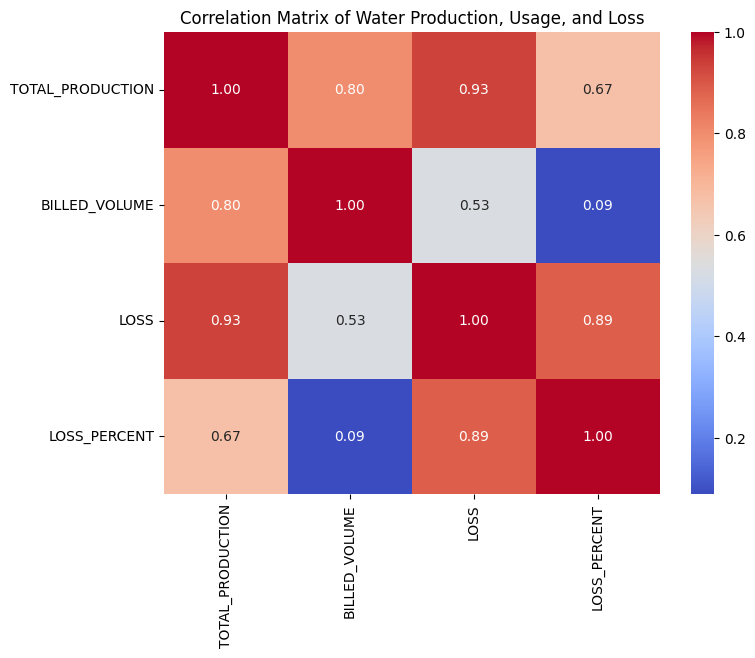

In [55]:
# Select numeric columns
numeric_cols = ['TOTAL_PRODUCTION', 'BILLED_VOLUME', 'LOSS', 'LOSS_PERCENT']

# Correlation matrix
corr_matrix = df_result[numeric_cols].corr()

print(corr_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Water Production, Usage, and Loss")
plt.show()


The correlation analysis of water production, billed volume, and losses highlights key relationships in the system. Total water production is strongly associated with both absolute losses (correlation ≈ 0.93) and, to a lesser extent, the percentage of water lost (≈ 0.67), indicating that higher production generally leads to more water being lost. 

Billed volume is moderately correlated with absolute losses (≈ 0.53) but shows almost no relationship with loss percentage (≈ 0.09), suggesting that customer consumption has little influence on the proportion of water lost. Finally, absolute losses and percentage losses are strongly linked (≈ 0.89), reflecting that periods with high water loss tend to also have a higher fraction of water lost. Overall, these patterns emphasize that controlling production and system efficiency is critical for reducing both the volume and proportion of water loss.

In [56]:
# Calculate correlation
correlation = df_filtered['BILL_AMOUNT'].corr(df_filtered['WATER_AMOUNT'])
print("Correlation between BILL_AMOUNT and WATER_AMOUNT:", correlation)


Correlation between BILL_AMOUNT and WATER_AMOUNT: 0.9593769448769108


The correlation between BILL_AMOUNT and WATER_AMOUNT is 0.96, indicating a very strong positive relationship. This shows that higher water consumption is closely associated with higher billing amounts.

#### Correlation between bill volume and meter size

In [ ]:
correlation = df_filtered['METER_SIZE'].corr(df_filtered['BILL_VOLUME'])
print("Correlation between BILL_VOLUME and METER_SIZE:", correlation)

Correlation between BILL_AMOUNT and METER_SIZE: 0.38622605759524725


The correlation between METER SIZE AND BILL VOLUME is quite small suggesting little to no relationship.

### CUSTOMER SEGMENTATION

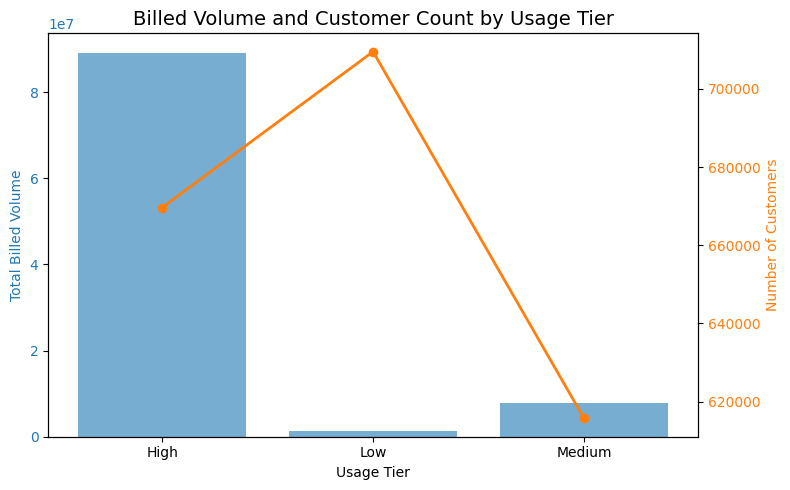

In [74]:
# Calculate quartiles
Q1 = df_filtered['BILL_VOLUME'].quantile(0.33)
Q2 = df_filtered['BILL_VOLUME'].quantile(0.66)

# Define usage tiers
def usage_tier(volume):
    if volume <= Q1:
        return 'Low'
    elif volume <= Q2:
        return 'Medium'
    else:
        return 'High'

df_filtered['USAGE_TIER'] = df_filtered['BILL_VOLUME'].apply(usage_tier)

# Calculate number of customers per tier
tier_counts = df_filtered.groupby('USAGE_TIER')['BILL_VOLUME'].count().reset_index()
tier_counts = tier_counts.rename(columns={'BILL_VOLUME': 'CUSTOMER_COUNT'})

# Aggregate billed volume per tier
tier_summary = df_filtered.groupby('USAGE_TIER')['BILL_VOLUME'].sum().reset_index()

# Merge the two
tier_summary = tier_summary.merge(tier_counts, on='USAGE_TIER')

# Melt for plotting
tier_plot = tier_summary.melt(id_vars='USAGE_TIER', value_vars=['BILL_VOLUME', 'CUSTOMER_COUNT'],
                              var_name='Metric', value_name='Value')
fig, ax1 = plt.subplots(figsize=(8,5))
# Left axis - Billed volume
color = 'tab:blue'
ax1.bar(tier_summary['USAGE_TIER'], tier_summary['BILL_VOLUME'], color=color, alpha=0.6, label='Billed Volume')
ax1.set_xlabel('Usage Tier')
ax1.set_ylabel('Total Billed Volume', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Right axis - Customer count
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.plot(tier_summary['USAGE_TIER'], tier_summary['CUSTOMER_COUNT'], color=color, marker='o', linewidth=2, label='Customer Count')
ax2.set_ylabel('Number of Customers', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Billed Volume and Customer Count by Usage Tier', fontsize=14)
fig.tight_layout()
plt.show()

From this chart the relationship between water consumption and customer distribution across usage tiersis clearly seen. The bars represent the total billed volume per tier, while the line shows the number of customers in each tier.

It is clear that High usage customers, although fewer in number, contribute a disproportionately large share of total billed volume, while Low and Medium users are more numerous but contribute less individually. This insight is valuable for targeting interventions, optimizing billing strategies, or **implementing smart metering** for high-consumption households.

### Filtering the High consumers as candidates for smart metering

In [57]:

df_filtered['BILL_VOLUME'].sort_values(ascending=False).reset_index(drop=True).median()

np.float64(12.0)

In [58]:
df_filtered['BILL_VOLUME'].sort_values(ascending=False).reset_index(drop=True).mean()

np.float64(49.23648053544995)

In [59]:
Q1 = df_filtered['BILL_VOLUME'].quantile(0.25)
Q3 = df_filtered['BILL_VOLUME'].quantile(0.75)
IQR = Q3 - Q1
high_cutoff = Q3 + 1.5 * IQR
print(high_cutoff)


68.0


In [60]:
len(df_filtered[df_filtered['BILL_VOLUME'] > 68]) / len(df_filtered) * 100

11.063606236556229

To understand patterns of water consumption, we analyzed the distribution of billed water volumes among customers. The median monthly usage was found to be 12 units, representing the midpoint of the dataset, while the mean usage was substantially higher at approximately 49.2 units, indicating that a small number of extremely high consumers are pulling the average upward. This discrepancy highlights a skewed distribution with a long tail of high users.

To systematically identify these high water users, we employed the Interquartile Range (IQR) method. The first quartile (Q1) and third quartile (Q3) were calculated to define the range containing the middle 50% of customers. Any user with billed volume above the threshold of 68 units, defined as Q3 plus 1.5 times the IQR, was classified as a high consumer. This method isolates unusually high water consumption, identifying approximately 11% of users who are prime candidates for smart metering and targeted interventions.

In [61]:
high_consumers_df = df_filtered[df_filtered['BILL_VOLUME'] > 68]
high_consumers_df

,REGION,ZONE,SUB_ZONE,INSTALLATION_KEY,INST_TYPE_CODE,INSTALLATION_TYPE_DESC,METER_SIZE,BILL_ESTIMATE_ACTUAL,BILL_VALID_INVALID,MAIN_SERVICE,SHADOW_SERVICE,WATER_AMOUNT,SEWER_AMOUNT,BILL_AMOUNT,BILL_VOLUME,MONTH,YEAR,NEGATIVE
8,WESTLANDS,KITUSURU,WAIYAKI WAY,CV-7000010,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,,7771.0,0.0,7771.0,111.0,August,2024.0,False
11,KASARANI,HUNTERS -MWIKI,HUNTERS,CV-7000013,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,,6424.0,0.0,6424.0,91.0,August,2024.0,False
39,WESTLANDS,KITUSURU,WAIYAKI WAY,CV-7000027,DOM,DOMESTIC,0.5,ACTUAL,VALID,WAT,SEW,4904.0,3127.0,8031.0,71.0,August,2024.0,False
56,DAGORETTI,KAWANGWARE,RIARA,CV-7000116,COM,COMMERCIAL,2.0,ACTUAL,VALID,WAT,SEW,61550.0,40458.0,102008.0,785.0,August,2024.0,False
68,WESTLANDS,PARKLANDS,BROOKSIDE,CV-7000128,COM,COMMERCIAL,0.5,ACTUAL,VALID,WAT,SEW,59628.0,39267.0,98895.0,759.0,August,2024.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2464232,WESTLANDS,PARKLANDS,HIGHRIDGE,CV-7138838,GOV-FND,PRIMARY AND SECONDARY SCHOOLS,1.5,ACTUAL,VALID,,SEW,0.0,11051.0,11051.0,257.0,May,2025.0,False
2464235,WESTLANDS,PARKLANDS,HIGHRIDGE,CV-7172088,COM,COMMERCIAL,0.75,ACTUAL,VALID,WAT,SEW,10751.0,6655.0,17406.0,147.0,May,2025.0,False
2464237,WESTLANDS,PARKLANDS,HIGHRIDGE,CV-7109951,COM-CONS,MAJOR CONSTRUCTION SITES>300M3,0.5,ACTUAL,VALID,WAT,SEW,7943.0,4900.0,12843.0,111.0,May,2025.0,False
2464238,WESTLANDS,PARKLANDS,HIGHRIDGE,IN-001239095,COM-CONS,MAJOR CONSTRUCTION SITES>300M3,0.5,ACTUAL,VALID,WAT,SEW,16133.0,10191.0,26324.0,216.0,May,2025.0,False
